<a href="https://colab.research.google.com/github/rohanp031/Handwritten-Digit-Recognition-with-LeNet5-Model-in-PyTorch/blob/main/Handwritten_Digit_Recognition_with_LeNet5_Model_in_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import the struct module to interpret bytes as packed binary data
import struct
# Import the numpy library for numerical operations
import numpy as np
# Import the matplotlib library for plotting
import matplotlib.pyplot as plt

def read_idx(filename):
    """
    Reads an IDX file and returns the data as a NumPy array.

    Parameters:
    filename (str): The path to the IDX file.

    Returns:
    np.ndarray: The data contained in the IDX file as a NumPy array.
    """
    with open(filename, 'rb') as f:
        magic_number = struct.unpack('>I', f.read(4))[0]  # Read the magic number (4 bytes)
        dims = magic_number & 0xFF  # Extract the number of dimensions from the magic number
        shape = tuple(struct.unpack('>I', f.read(4))[0] for _ in range(dims))  # Read dimensions
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)  # Read the data

# Load the images and labels from the IDX files
images = read_idx('t10k-images.idx3-ubyte')
labels = read_idx('t10k-labels.idx1-ubyte')

# Display an example image
plt.imshow(images[0], cmap='gray')
plt.title(f'Label: {labels[0]}')
plt.show()


error: unpack requires a buffer of 4 bytes

In [ ]:
# Print the shape of the images array
print(f'Images shape: {images.shape}')
# Images shape: (num_images, height, width)
# This prints the dimensions of the images array. The shape is a tuple where:
# - The first element is the number of images.
# - The second element is the height of each image.
# - The third element is the width of each image.

# Print the shape of the labels array
print(f'Labels shape: {labels.shape}')
# Labels shape: (num_labels,)
# This prints the dimensions of the labels array. The shape is a tuple where:
# - The single element is the number of labels.
# Each label corresponds to an image.

# Print the number of images
print(f'Number of images: {len(images)}')
# Number of images: num_images
# This prints the number of images by getting the length of the images array.
# It should match the first element of the images shape.

# Print the number of labels
print(f'Number of labels: {len(labels)}')
# Number of labels: num_labels
# This prints the number of labels by getting the length of the labels array.
# It should match the number of images.

In [ ]:
import torch

# Assuming you've loaded your data using the provided functions
images = read_idx('t10k-images.idx3-ubyte')
labels = read_idx('t10k-labels.idx1-ubyte')

# Define LeNet input shape (assuming grayscale images)
leNet_input_shape = (1, 28, 28)

# Reshape images to match LeNet's input shape
reshaped_images = images.reshape(-1, *leNet_input_shape)  # Reshape with -1 for batch size

print("Original images shape:", images.shape)
print("Reshaped images shape:", reshaped_images.shape)

# Convert data type to float for PyTorch (optional, might be needed depending on your model)
reshaped_images = reshaped_images.astype(np.float32) / 255.0  # Normalize pixel values

print("Data type after reshaping:", reshaped_images.dtype)


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the datasets with the defined transformations
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Define a custom collate function for one-hot encoding
def one_hot_collate(batch, num_classes=10):
    images, labels = zip(*batch)
    images = torch.stack(images)
    labels = torch.tensor(labels)
    one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=num_classes).float()
    return images, one_hot_labels

# Use the custom collate function in the DataLoader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, collate_fn=lambda x: one_hot_collate(x))
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, collate_fn=lambda x: one_hot_collate(x))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show a batch of images and labels
def show_batch(batch):
    images, labels = batch
    batch_size = len(images)
    nrows = int(np.sqrt(batch_size))
    ncols = (batch_size // nrows) + (batch_size % nrows > 0)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.5)
    for i, ax in enumerate(axes.flat):
        if i < batch_size:
            ax.imshow(images[i][0], cmap='gray')
            ax.set_title(f'Label: {labels[i].argmax().item()}', fontsize=10, pad=10)
        ax.axis('off')
    plt.show()

# Display a batch of images and their one-hot encoded labels
dataiter = iter(trainloader)
batch = next(dataiter)
show_batch(batch)


In [ ]:
# Display a sample of one-hot encoded labels
def display_sample_labels(loader, num_samples=5):
    dataiter = iter(loader)
    images, one_hot_labels = next(dataiter)
    print("Sample One-Hot Encoded Labels:")
    for i in range(num_samples):
        print(f"Label {i}: {one_hot_labels[i]}")

# Display sample one-hot encoded labels from the trainloader
display_sample_labels(trainloader, num_samples=5)
# Count the number of images per class and visualize the distribution
def visualize_class_distribution(loader):
    class_counts = torch.zeros(10)
    for images, one_hot_labels in loader:
        labels = one_hot_labels.argmax(dim=1)
        for label in labels:
            class_counts[label] += 1

    # Plot the distribution
    classes = [str(i) for i in range(10)]
    plt.figure(figsize=(10, 5))
    plt.bar(classes, class_counts)
    plt.xlabel('Class')
    plt.ylabel('Number of images')
    plt.title('Distribution of Images per Class')
    plt.show()

# Visualize the distribution of images per class in the trainloader
visualize_class_distribution(trainloader)


In [ ]:
# Function to show a batch of images with their dimensions and labels
def show_batch(batch):
    images, one_hot_labels = batch
    labels = one_hot_labels.argmax(dim=1)  # Convert one-hot labels to class indices
    batch_size = len(images)
    nrows = int(np.sqrt(batch_size))
    ncols = (batch_size // nrows) + (batch_size % nrows > 0)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))  # Increased figure size
    fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Added more space between subplots
    for i, ax in enumerate(axes.flat):
        if i < batch_size:
            image = images[i][0]
            ax.imshow(image, cmap='gray')
            ax.set_title(f'Label: {labels[i].item()}', fontsize=10, pad=10)
            # Set custom ticks to show dimensions
            ax.set_xticks([0, image.shape[1]//2, image.shape[1]])
            ax.set_xticklabels([0, image.shape[1]//2, image.shape[1]])
            ax.set_yticks([0, image.shape[0]//2, image.shape[0]])
            ax.set_yticklabels([0, image.shape[0]//2, image.shape[0]])
        ax.axis('on')
    plt.show()

# Load a batch and display it
dataiter = iter(trainloader)
batch = next(dataiter)
show_batch(batch)

In [ ]:
from torch.utils.data import random_split

# Define the sizes of train, validation, and test sets
train_size = int(0.7 * len(images))

test_size = len(images) - train_size

# Split the dataset
train_dataset,  test_dataset = random_split(images, [train_size, test_size])

In [ ]:
#print sizes of train, validation, and test sets
print(f"Number of samples in the training set: {len(train_dataset)}")

print(f"Number of samples in the test set: {len(test_dataset)}")

In [ ]:
# Sizes of train and test sets
sizes = [len(train_dataset), len(test_dataset)]
labels = ['Train', 'Test']

# Plotting the bar chart
plt.figure(figsize=(6, 4))
plt.bar(labels, sizes, color=['blue', 'red'])
plt.xlabel('Dataset Split')
plt.ylabel('Number of Samples')
plt.title('Distribution of Dataset Split')
plt.show()


In [ ]:
import struct
import numpy as np
import matplotlib.pyplot as plt

def read_idx(filename):
    """
    Reads an IDX file and returns the data as a NumPy array.

    Parameters:
    filename (str): The path to the IDX file.

    Returns:
    np.ndarray: The data contained in the IDX file as a NumPy array.
    """
    with open(filename, 'rb') as f:
        # Read the magic number (first 4 bytes)
        magic = struct.unpack('>I', f.read(4))[0]
        # Read the number of dimensions (next byte)
        dims = magic & 0xFF
        # Read the dimensions (next dims * 4 bytes)
        shape = tuple(struct.unpack('>I', f.read(4))[0] for _ in range(dims))
        # Read the rest of the file content and convert it into a NumPy array
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

# Load the images and labels from the IDX files
images = read_idx('t10k-images.idx3-ubyte')
labels = read_idx('t10k-labels.idx1-ubyte')


In [ ]:
import torch.optim as optim

# Define the loss function (Cross-Entropy Loss for classification)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam optimizer with a learning rate of 0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
import torch


# Number of epochs to train
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to GPU
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels.argmax(dim=1))  # Use argmax to get class indices from one-hot encoded labels

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches
            print(f'[Epoch {epoch + 1}, Mini-batch {i + 1}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')


In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'lenet5.pth')
print('Model saved as lenet5.pth')

# Ensure the model is in evaluation mode
model.eval()

correct = 0
total = 0

# Disable gradient calculation for evaluation
with torch.no_grad():
    for images, labels in testloader:
        # Move inputs and labels to GPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.argmax(dim=1)).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

# Ensure the model is back to training mode if needed
model.train()


In [ ]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Calculate the confusion matrix
all_labels = []
all_predictions = []
with torch.no_grad():
    for images, labels in testloader:
        # Move inputs and labels to GPU
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_labels, all_predictions)
plot_confusion_matrix(cm, classes=[str(i) for i in range(10)])


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the datasets with the defined transformations
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Define a custom collate function for one-hot encoding
def one_hot_collate(batch, num_classes=10):
    images, labels = zip(*batch)
    images = torch.stack(images)
    labels = torch.tensor(labels)
    one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=num_classes).float()
    return images, one_hot_labels

# Use the custom collate function in the DataLoader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, collate_fn=lambda x: one_hot_collate(x))
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, collate_fn=lambda x: one_hot_collate(x))




In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Convert DataLoader to NumPy arrays
def dataloader_to_numpy(dataloader):
    images_list, labels_list = [], []
    for images, labels in dataloader:
        images_list.append(images)
        labels_list.append(labels)
    return np.concatenate(images_list), np.concatenate(labels_list)

train_images, train_labels = dataloader_to_numpy(trainloader)
test_images, test_labels = dataloader_to_numpy(testloader)

# Reshape images to add the channel dimension
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)

# Define the CNN model
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Increased dropout for regularization
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define a learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Train the model
history = model.fit(train_images, train_labels, epochs=20, batch_size=64, validation_split=0.2, callbacks=[lr_callback])

# Save the trained model
model.save('cnn_model.h5')
print('Model saved as cnn_model.h5')

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.2%}")

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


In [ ]:
pip install tqdm


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = 28 * 28  # MNIST image size is 28x28
hidden_size = 500
num_classes = 10
num_epochs = 20
batch_size = 100
learning_rate = 0.001

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Define the model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input images
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = MLP(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
train_accuracy_history = []
val_accuracy_history = []

total_step = len(train_loader)
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    correct = 0
    total = 0
    epoch_loss = 0  # Track total loss for the epoch
    with tqdm(total=total_step, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            pbar.set_postfix({'loss': epoch_loss / (i + 1), 'accuracy': correct / total})
            pbar.update()

    train_accuracy = correct / total
    train_accuracy_history.append(train_accuracy)

    # Evaluate on validation set
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_accuracy = correct / total
        val_accuracy_history.append(val_accuracy)

    print ('Epoch [{}/{}], Train Accuracy: {:.4f}, Val Accuracy: {:.4f}, Loss: {:.4f}'
           .format(epoch+1, num_epochs, train_accuracy, val_accuracy, epoch_loss / len(train_loader)))

# Save the model
torch.save(model.state_dict(), 'mlp_model.pth')

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_accuracy = correct / total
    print('Test accuracy: {:.2%}'.format(test_accuracy))

# Plot training history
plt.plot(range(1, num_epochs+1), train_accuracy_history, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracy_history, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training History')
plt.legend()
plt.show()


In [ ]:
# Define the model again
model = MLP(input_size, hidden_size, num_classes)
model.load_state_dict(torch.load('mlp_model.pth'))
model.to(device)
model.eval()

# Function to predict the class of a single image
def predict_single_image(image):
    image = image.to(device)
    image = image.view(1, -1)  # Flatten the image
    outputs = model(image)
    _, predicted = torch.max(outputs.data, 1)
    return predicted.item()

# Test the loaded model with a sample from the test set
sample_image, sample_label = test_dataset[0]  # Get the first sample from the test dataset
sample_image = sample_image.view(1, 28, 28)  # Reshape for visualization

# Display the image
plt.imshow(sample_image.squeeze(), cmap='gray')
plt.title(f'True Label: {sample_label}')
plt.show()

# Predict the label
sample_image = sample_image.view(1, -1)  # Flatten the image
sample_image = sample_image.to(device)
predicted_label = predict_single_image(sample_image)
print(f'Predicted Label: {predicted_label}')


In [ ]:
!pip install streamlit localtunnel tensorflow


In [ ]:
%%writefile app.py
import streamlit as st
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model
import cv2

# Define the MLP model architecture
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Load the MLP model
input_size = 28 * 28
hidden_size = 500
num_classes = 10
mlp_model = MLP(input_size, hidden_size, num_classes)
mlp_model.load_state_dict(torch.load('mlp_model.pth', map_location=torch.device('cpu')))
mlp_model.eval()

# Load the CNN model
cnn_model = load_model('cnn_model.h5')

# Define the transformation for incoming images for MLP
mlp_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def predict_image(image):
    pil_image = Image.open(image).convert('L')

    # MLP prediction
    mlp_image = mlp_transform(pil_image).unsqueeze(0)
    with torch.no_grad():
        mlp_outputs = mlp_model(mlp_image)
        _, mlp_predicted = torch.max(mlp_outputs.data, 1)
        mlp_result = mlp_predicted.item()

    # CNN prediction
    cnn_image = np.array(pil_image.resize((28, 28)))
    cnn_image = np.expand_dims(cnn_image, axis=-1)
    cnn_image = np.expand_dims(cnn_image, axis=0)
    cnn_prediction = cnn_model.predict(cnn_image)
    cnn_result = np.argmax(cnn_prediction)

    return mlp_result, cnn_result

st.title("Digit Prediction with MLP and CNN")
st.write("Upload an image to get predictions from both MLP and CNN models.")

uploaded_file = st.file_uploader("Choose an image...", type="png")

if uploaded_file is not None:
    mlp_result, cnn_result = predict_image(uploaded_file)
    st.image(uploaded_file, caption='Uploaded Image', use_column_width=True)
    st.write(f"MLP Prediction: {mlp_result}")
    st.write(f"CNN Prediction: {cnn_result}")


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501


Epoch 1/20: 100%|██████████| 600/600 [00:12<00:00, 49.19batch/s, loss=0.292, accuracy=0.919]


Epoch [1/20], Train Accuracy: 0.9195, Val Accuracy: 0.9539, Loss: 0.2918


Epoch 2/20: 100%|██████████| 600/600 [00:09<00:00, 61.96batch/s, loss=0.118, accuracy=0.965]


Epoch [2/20], Train Accuracy: 0.9652, Val Accuracy: 0.9680, Loss: 0.1184


Epoch 3/20: 100%|██████████| 600/600 [00:09<00:00, 62.59batch/s, loss=0.0764, accuracy=0.977]


Epoch [3/20], Train Accuracy: 0.9772, Val Accuracy: 0.9748, Loss: 0.0764


Epoch 4/20: 100%|██████████| 600/600 [00:09<00:00, 62.86batch/s, loss=0.0552, accuracy=0.983]


Epoch [4/20], Train Accuracy: 0.9831, Val Accuracy: 0.9785, Loss: 0.0552


Epoch 5/20: 100%|██████████| 600/600 [00:10<00:00, 59.27batch/s, loss=0.0407, accuracy=0.988]


Epoch [5/20], Train Accuracy: 0.9879, Val Accuracy: 0.9799, Loss: 0.0407


Epoch 6/20: 100%|██████████| 600/600 [00:09<00:00, 60.06batch/s, loss=0.0307, accuracy=0.991]


Epoch [6/20], Train Accuracy: 0.9906, Val Accuracy: 0.9809, Loss: 0.0307


Epoch 7/20: 100%|██████████| 600/600 [00:10<00:00, 59.89batch/s, loss=0.023, accuracy=0.994]


Epoch [7/20], Train Accuracy: 0.9936, Val Accuracy: 0.9806, Loss: 0.0230


Epoch 8/20: 100%|██████████| 600/600 [00:10<00:00, 59.90batch/s, loss=0.017, accuracy=0.995]


Epoch [8/20], Train Accuracy: 0.9953, Val Accuracy: 0.9805, Loss: 0.0170


Epoch 9/20: 100%|██████████| 600/600 [00:10<00:00, 59.80batch/s, loss=0.0139, accuracy=0.996]


Epoch [9/20], Train Accuracy: 0.9960, Val Accuracy: 0.9812, Loss: 0.0139


Epoch 10/20: 100%|██████████| 600/600 [00:09<00:00, 60.30batch/s, loss=0.012, accuracy=0.997]


Epoch [10/20], Train Accuracy: 0.9967, Val Accuracy: 0.9813, Loss: 0.0120


Epoch 11/20: 100%|██████████| 600/600 [00:09<00:00, 60.75batch/s, loss=0.00834, accuracy=0.998]


Epoch [11/20], Train Accuracy: 0.9980, Val Accuracy: 0.9830, Loss: 0.0083


Epoch 12/20: 100%|██████████| 600/600 [00:09<00:00, 63.10batch/s, loss=0.00618, accuracy=0.999]


Epoch [12/20], Train Accuracy: 0.9985, Val Accuracy: 0.9786, Loss: 0.0062


Epoch 13/20: 100%|██████████| 600/600 [00:09<00:00, 62.63batch/s, loss=0.00661, accuracy=0.998]


Epoch [13/20], Train Accuracy: 0.9982, Val Accuracy: 0.9791, Loss: 0.0066


Epoch 14/20: 100%|██████████| 600/600 [00:10<00:00, 57.73batch/s, loss=0.00674, accuracy=0.998]


Epoch [14/20], Train Accuracy: 0.9980, Val Accuracy: 0.9796, Loss: 0.0067


Epoch 15/20: 100%|██████████| 600/600 [00:11<00:00, 52.51batch/s, loss=0.00656, accuracy=0.998]


Epoch [15/20], Train Accuracy: 0.9983, Val Accuracy: 0.9822, Loss: 0.0066


Epoch 16/20: 100%|██████████| 600/600 [00:11<00:00, 52.77batch/s, loss=0.00684, accuracy=0.998]


Epoch [16/20], Train Accuracy: 0.9979, Val Accuracy: 0.9797, Loss: 0.0068


Epoch 17/20: 100%|██████████| 600/600 [00:11<00:00, 51.97batch/s, loss=0.0028, accuracy=0.999]


Epoch [17/20], Train Accuracy: 0.9993, Val Accuracy: 0.9828, Loss: 0.0028


Epoch 18/20: 100%|██████████| 600/600 [00:11<00:00, 52.85batch/s, loss=0.000685, accuracy=1]


Epoch [18/20], Train Accuracy: 1.0000, Val Accuracy: 0.9839, Loss: 0.0007


Epoch 19/20: 100%|██████████| 600/600 [00:11<00:00, 53.03batch/s, loss=0.00442, accuracy=0.999]


Epoch [19/20], Train Accuracy: 0.9987, Val Accuracy: 0.9769, Loss: 0.0044


Epoch 20/20: 100%|██████████| 600/600 [00:11<00:00, 53.00batch/s, loss=0.00968, accuracy=0.997]


Epoch [20/20], Train Accuracy: 0.9965, Val Accuracy: 0.9805, Loss: 0.0097


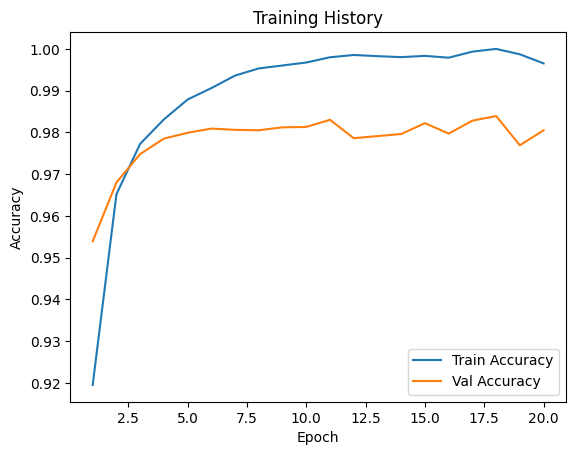

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = 28 * 28  # MNIST image size is 28x28
hidden_size = 500
num_classes = 10
num_epochs = 20
batch_size = 100
learning_rate = 0.001

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Define the model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input images
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = MLP(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
train_accuracy_history = []
val_accuracy_history = []

total_step = len(train_loader)
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    correct = 0
    total = 0
    epoch_loss = 0  # Track total loss for the epoch
    with tqdm(total=total_step, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            pbar.set_postfix({'loss': epoch_loss / (i + 1), 'accuracy': correct / total})
            pbar.update()

    train_accuracy = correct / total
    train_accuracy_history.append(train_accuracy)

    # Evaluate on validation set
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_accuracy = correct / total
        val_accuracy_history.append(val_accuracy)

    print ('Epoch [{}/{}], Train Accuracy: {:.4f}, Val Accuracy: {:.4f}, Loss: {:.4f}'
           .format(epoch+1, num_epochs, train_accuracy, val_accuracy, epoch_loss / len(train_loader)))

# Save the model
torch.save(model.state_dict(), 'mlp_model.pth')

# Plot training history
plt.plot(range(1, num_epochs+1), train_accuracy_history, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracy_history, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training History')
plt.legend()
plt.show()


In [ ]:
pip install Flask


In [ ]:
from flask import Flask, request, jsonify
import torch
import torchvision.transforms as transforms
from PIL import Image
import io

app = Flask(__name__)

# Define the model again and load the saved model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input images
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

input_size = 28 * 28
hidden_size = 500
num_classes = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLP(input_size, hidden_size, num_classes)
model.load_state_dict(torch.load('mlp_model.pth'))
model.to(device)
model.eval()

# Function to preprocess the uploaded image
def preprocess_image(image_bytes):
    image = Image.open(io.BytesIO(image_bytes)).convert('L')  # Convert image to grayscale
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to match the training conditions
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Function to predict the class of a single image
def predict_single_image(image):
    image = image.to(device)
    outputs = model(image)
    _, predicted = torch.max(outputs.data, 1)
    return predicted.item()

@app.route('/predict', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return jsonify({'error': 'No file provided'}), 400
    file = request.files['file']
    img_bytes = file.read()
    image = preprocess_image(img_bytes)
    predicted_label = predict_single_image(image)
    return jsonify({'predicted_label': predicted_label})

if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
